The sentiment labels are:

0 - negative

1 - somewhat negative

2 - neutral

3 - somewhat positive

4 - positive

### Dependencies

In [1]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import ngrams
from bs4 import BeautifulSoup
from nltk.tokenize import WordPunctTokenizer
from nltk.corpus import stopwords 
import string
from collections import Counter
from sklearn.model_selection import train_test_split
import re
import nltk
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

## Explanation Data

#### Read Data

In [2]:
train = pd.read_csv('train.tsv', sep="\t")
test = pd.read_csv('test.tsv', sep="\t")

In [9]:
train.shape

(156060, 4)

In [8]:
train[train.Sentiment==2].shape

(79582, 4)

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine
...,...,...,...
66287,222348,11855,"A long-winded , predictable scenario ."
66288,222349,11855,"A long-winded , predictable scenario"
66289,222350,11855,"A long-winded ,"
66290,222351,11855,A long-winded


In [9]:
#for counting ham and spam

train.Sentiment.value_counts()

2    79582
3    32927
1    27273
4     9206
0     7072
Name: Sentiment, dtype: int64

In [10]:
train.groupby('Sentiment').describe()

PhraseId                                                        \
             count          mean           std    min       25%      50%   
Sentiment                                                                  
0           7072.0  81035.048784  43705.802913  102.0  44891.00  81796.0   
1          27273.0  80495.252447  45125.763868    1.0  41566.00  81334.0   
2          79582.0  76527.962441  45351.766531    2.0  36798.00  76188.5   
3          32927.0  78409.828378  44596.812258   22.0  40094.00  78068.0   
4           9206.0  80052.598197  44310.325650   64.0  42766.75  80185.0   

                              SentenceId                                 \
                75%       max      count         mean          std  min   
Sentiment                                                                 
0          117412.0  155974.0     7072.0  4241.946126  2434.936265  3.0   
1          119969.0  156057.0    27273.0  4216.860265  2510.922820  1.0   
2          115680.5  156060.0    79582.0  3997.699090  2516.081021  1.0   
3          117275.5  156058.0    32927.0  4098.831597  2480.081070  1.0   
4          118439.0  156011.0     9206.0  4189.713448  2466.092532  2.0   

                                             
               25%     50%      75%     max  
Sentiment                                    
0          2177.00  4221.0  6265.25  8539.0  
1          2001.00  4192.0  6416.00  8544.0  
2          1743.25  3909.0  6164.00  8544.0  
3          1919.00  4018.0  6257.00  8544.0  
4          2064.25  4131.0  6327.75  8541.0

## Clean Data

In [11]:
tok = WordPunctTokenizer()

pat1 = r'@[A-Za-z0-9_]+'
pat2 = r'https?://[^ ]+'
combined_pat = r'|'.join((pat1, pat2))
www_pat = r'www.[^ ]+'
negations_dic = {"isn't":"is not", "aren't":"are not", "wasn't":"was not", "weren't":"were not",
                "haven't":"have not","hasn't":"has not","hadn't":"had not","won't":"will not",
                "wouldn't":"would not", "don't":"do not", "doesn't":"does not","didn't":"did not",
                "can't":"can not","couldn't":"could not","shouldn't":"should not","mightn't":"might not",
                "mustn't":"must not"}
neg_pattern = re.compile(r'\b(' + '|'.join(negations_dic.keys()) + r')\b')

def tweet_cleaner_updated(text):
    soup = BeautifulSoup(text, 'lxml')
    souped = soup.get_text()
    try:
        bom_removed = souped.decode("utf-8-sig").replace(u"\ufffd", "?")
    except:
        bom_removed = souped
    stripped = re.sub(combined_pat, '', bom_removed)
    stripped = re.sub(www_pat, '', stripped)
    lower_case = stripped.lower()
    neg_handled = neg_pattern.sub(lambda x: negations_dic[x.group()], lower_case)
    letters_only = re.sub("[^a-zA-Z]", " ", neg_handled)
    # During the letters_only process two lines above, it has created unnecessay white spaces,
    # I will tokenize and join together to remove unneccessary white spaces
    words = [x for x  in tok.tokenize(letters_only) if len(x) > 1]
    return (" ".join(words)).strip()

### clean train

In [12]:
%%time
print ("Cleaning the tweets...\n")
clean_data = []
for row in train.Phrase:
    clean_data.append(tweet_cleaner_updated(row))

Cleaning the tweets...



/opt/anaconda3/lib/python3.7/site-packages/bs4/__init__.py:294: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)


CPU times: user 41.9 s, sys: 2.18 s, total: 44.1 s
Wall time: 44.1 s


In [13]:
len(clean_data)

156060

In [14]:
clean_df = pd.DataFrame(clean_data,columns=['Phrase'])
clean_df['PhraseId'] = train.PhraseId
clean_df['SentenceId'] = train.SentenceId
clean_df['Sentiment'] = train.Sentiment
clean_df.to_csv('cleaned_train_data.csv',encoding='utf-8')

In [15]:
csv = 'cleaned_train_data.csv'
cleaned_train_data = pd.read_csv(csv,index_col=0)
cleaned_train_data

,Phrase,PhraseId,SentenceId,Sentiment
0,series of escapades demonstrating the adage th...,1,1,1
1,series of escapades demonstrating the adage th...,2,1,2
2,series,3,1,2
3,NaN,4,1,2
4,series,5,1,2
...,...,...,...,...
156055,hearst,156056,8544,2
156056,forced avuncular chortles,156057,8544,1
156057,avuncular chortles,156058,8544,3
156058,avuncular,156059,8544,2


In [16]:
cleaned_train_data[cleaned_train_data.isnull().any(axis=1)]

,Phrase,PhraseId,SentenceId,Sentiment
3,NaN,4,1,2
37,NaN,38,1,2
62,NaN,63,1,2
92,NaN,93,3,2
98,NaN,99,3,2
...,...,...,...,...
152059,NaN,152060,8296,2
152069,NaN,152070,8296,2
153022,NaN,153023,8355,2
153530,NaN,153531,8384,2


In [17]:
cleaned_train_data.isnull().any(axis=0)

Phrase         True
PhraseId      False
SentenceId    False
Sentiment     False
dtype: bool

In [18]:
cleaned_train_data.dropna(inplace=True)
cleaned_train_data.reset_index(drop=True,inplace=True)
cleaned_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 155767 entries, 0 to 155766
Data columns (total 4 columns):
Phrase        155767 non-null object
PhraseId      155767 non-null int64
SentenceId    155767 non-null int64
Sentiment     155767 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.8+ MB


In [19]:
cleaned_train_data.shape

(155767, 4)

### clean test

In [20]:
%%time
print ("Cleaning the tweets...\n")
clean_data = []
for row in test.Phrase:
    clean_data.append(tweet_cleaner_updated(row))

Cleaning the tweets...

CPU times: user 18.6 s, sys: 1.02 s, total: 19.6 s
Wall time: 19.7 s


In [21]:
test.head()

,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine ...
1,156062,8545,An intermittently pleasing but mostly routine ...
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [22]:
clean_df = pd.DataFrame(clean_data, columns=['Phrase'])
clean_df['PhraseId'] = test.PhraseId
clean_df['SentenceId'] = test.SentenceId

clean_df.to_csv('cleaned_test_data.csv',encoding='utf-8')

In [23]:
csv = 'cleaned_test_data.csv'
cleaned_test_data = pd.read_csv(csv,index_col=0)
cleaned_test_data

,Phrase,PhraseId,SentenceId
0,an intermittently pleasing but mostly routine ...,156061,8545
1,an intermittently pleasing but mostly routine ...,156062,8545
2,an,156063,8545
3,intermittently pleasing but mostly routine effort,156064,8545
4,intermittently pleasing but mostly routine,156065,8545
...,...,...,...
66287,long winded predictable scenario,222348,11855
66288,long winded predictable scenario,222349,11855
66289,long winded,222350,11855
66290,long winded,222351,11855


In [24]:
cleaned_test_data[cleaned_test_data.isnull().any(axis=1)]

,Phrase,PhraseId,SentenceId
14,NaN,156075,8545
34,NaN,156095,8546
46,NaN,156107,8546
48,NaN,156109,8546
106,NaN,156167,8547
...,...,...,...
65718,NaN,221779,11819
65719,NaN,221780,11819
65722,NaN,221783,11819
65723,NaN,221784,11819


In [25]:
cleaned_test_data.dropna(inplace=True)
cleaned_test_data.reset_index(drop=True,inplace=True)
cleaned_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66122 entries, 0 to 66121
Data columns (total 3 columns):
Phrase        66122 non-null object
PhraseId      66122 non-null int64
SentenceId    66122 non-null int64
dtypes: int64(2), object(1)
memory usage: 1.5+ MB


## Data Visualition

Train Data

Text(0.5,1,'Distribution of Train Data')

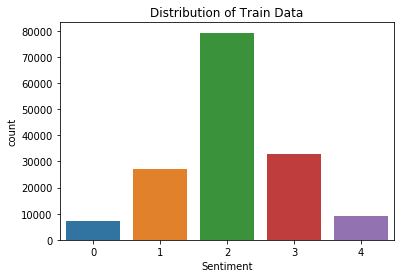

In [22]:
#plotting graph for distribution

sns.countplot(x = 'Sentiment', data = cleaned_train_data)
cleaned_train_data.loc[:,'Sentiment'].value_counts()
plt.title('Distribution of Train Data')

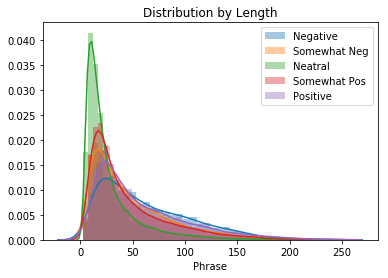

In [26]:
# plotting graph by length.

neg = cleaned_train_data[cleaned_train_data['Sentiment']== 0]['Phrase'].str.len()
sns.distplot(neg, label='Negative')
som_neg = cleaned_train_data[cleaned_train_data['Sentiment']== 1]['Phrase'].str.len()
sns.distplot(som_neg, label='Somewhat Neg')
neat = cleaned_train_data[cleaned_train_data['Sentiment']== 2]['Phrase'].str.len()
sns.distplot(neat, label='Neatral')
som_pos = cleaned_train_data[cleaned_train_data['Sentiment']== 3]['Phrase'].str.len()
sns.distplot(som_pos, label='Somewhat Pos')
pos = cleaned_train_data[cleaned_train_data['Sentiment']== 4]['Phrase'].str.len()
sns.distplot(pos, label='Positive')
plt.title('Distribution by Length')
plt.legend()

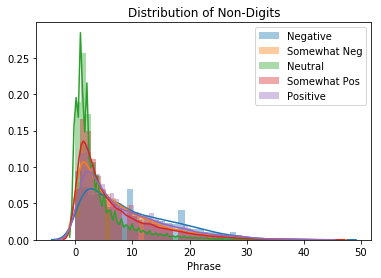

In [27]:
#plotting graph for non-digits.

neg = cleaned_train_data[cleaned_train_data['Sentiment'] == 0]['Phrase'].str.replace(r'\w+', '').str.len()
sns.distplot(neg, label='Negative')
som_neg = cleaned_train_data[cleaned_train_data['Sentiment'] == 1]['Phrase'].str.replace(r'\w+', '').str.len()
sns.distplot(som_neg, label='Somewhat Neg')
neutral = cleaned_train_data[cleaned_train_data['Sentiment'] == 2]['Phrase'].str.replace(r'\w+', '').str.len()
sns.distplot(neutral, label='Neutral')
som_pos = cleaned_train_data[cleaned_train_data['Sentiment'] == 3]['Phrase'].str.replace(r'\w+', '').str.len()
sns.distplot(som_pos, label='Somewhat Pos')
pos = cleaned_train_data[cleaned_train_data['Sentiment'] == 4]['Phrase'].str.replace(r'\w+', '').str.len()
sns.distplot(pos, label='Positive')
plt.title('Distribution of Non-Digits')
plt.legend()

In [28]:
from collections import Counter
#for counting frequently occurence of pos and neg.

count1 = Counter(" ".join(cleaned_train_data[cleaned_train_data['Sentiment']== 0]["Phrase"]).split()).most_common(30)
data1 = pd.DataFrame.from_dict(count1)
data1 = data1.rename(columns={0: "words of neg", 1 : "count"})

count2 = Counter(" ".join(cleaned_train_data[cleaned_train_data['Sentiment']== 1]["Phrase"]).split()).most_common(30)
data2 = pd.DataFrame.from_dict(count2)
data2 = data2.rename(columns={0: "words of somewhat_neg", 1 : "count_"})

count3 = Counter(" ".join(cleaned_train_data[cleaned_train_data['Sentiment']== 2]["Phrase"]).split()).most_common(30)
data3 = pd.DataFrame.from_dict(count3)
data3 = data3.rename(columns={0: "words of neutral", 1 : "count_"})

count4 = Counter(" ".join(cleaned_train_data[cleaned_train_data['Sentiment']== 3]["Phrase"]).split()).most_common(30)
data4 = pd.DataFrame.from_dict(count4)
data4 = data4.rename(columns={0: "words of somewhat_pos", 1 : "count_"})

count5 = Counter(" ".join(cleaned_train_data[cleaned_train_data['Sentiment']== 4]["Phrase"]).split()).most_common(30)
data5 = pd.DataFrame.from_dict(count5)
data5 = data5.rename(columns={0: "words of pos", 1 : "count_"})

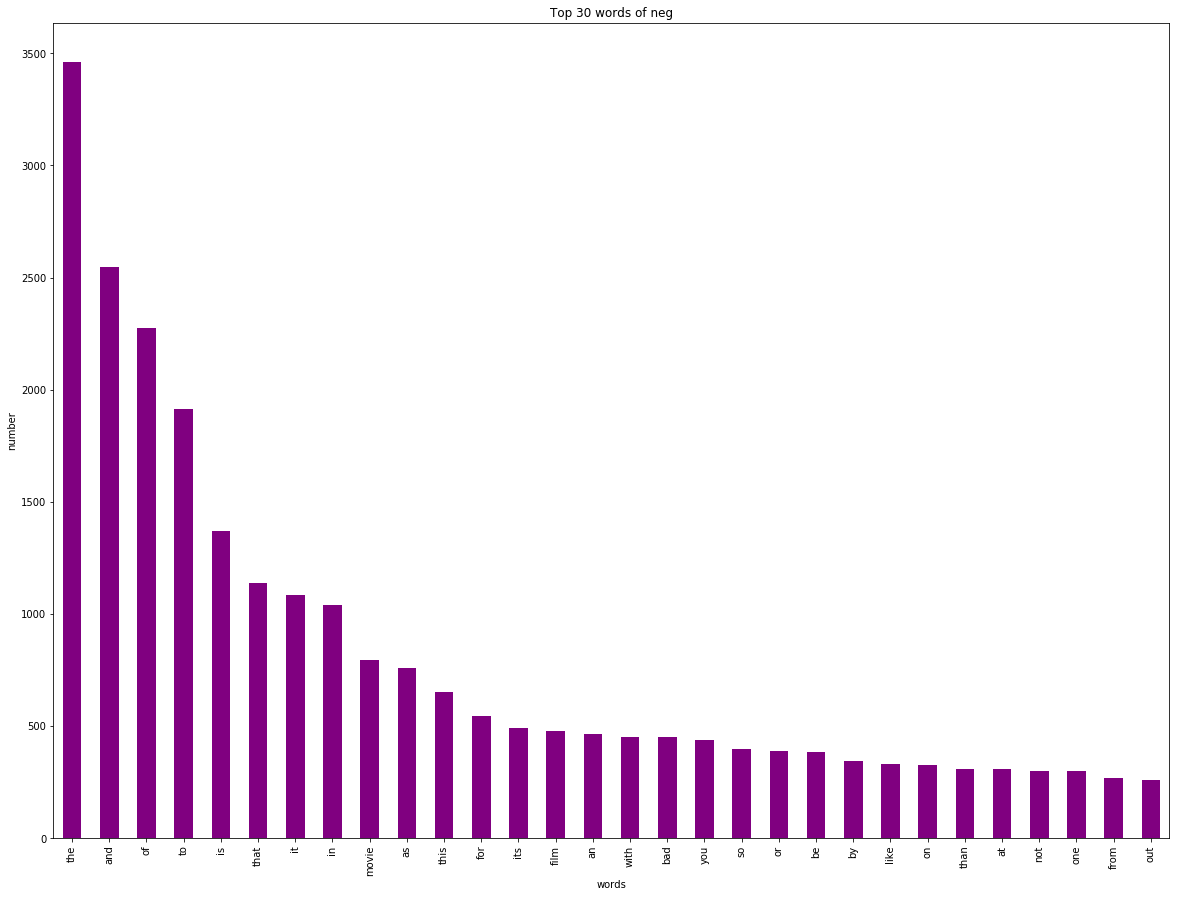

In [29]:
data1.plot.bar(legend = False, color = 'purple',figsize = (20,15))
y_neg = np.arange(len(data1["words of neg"]))
plt.xticks(y_neg, data1["words of neg"])
plt.title('Top 30 words of neg')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

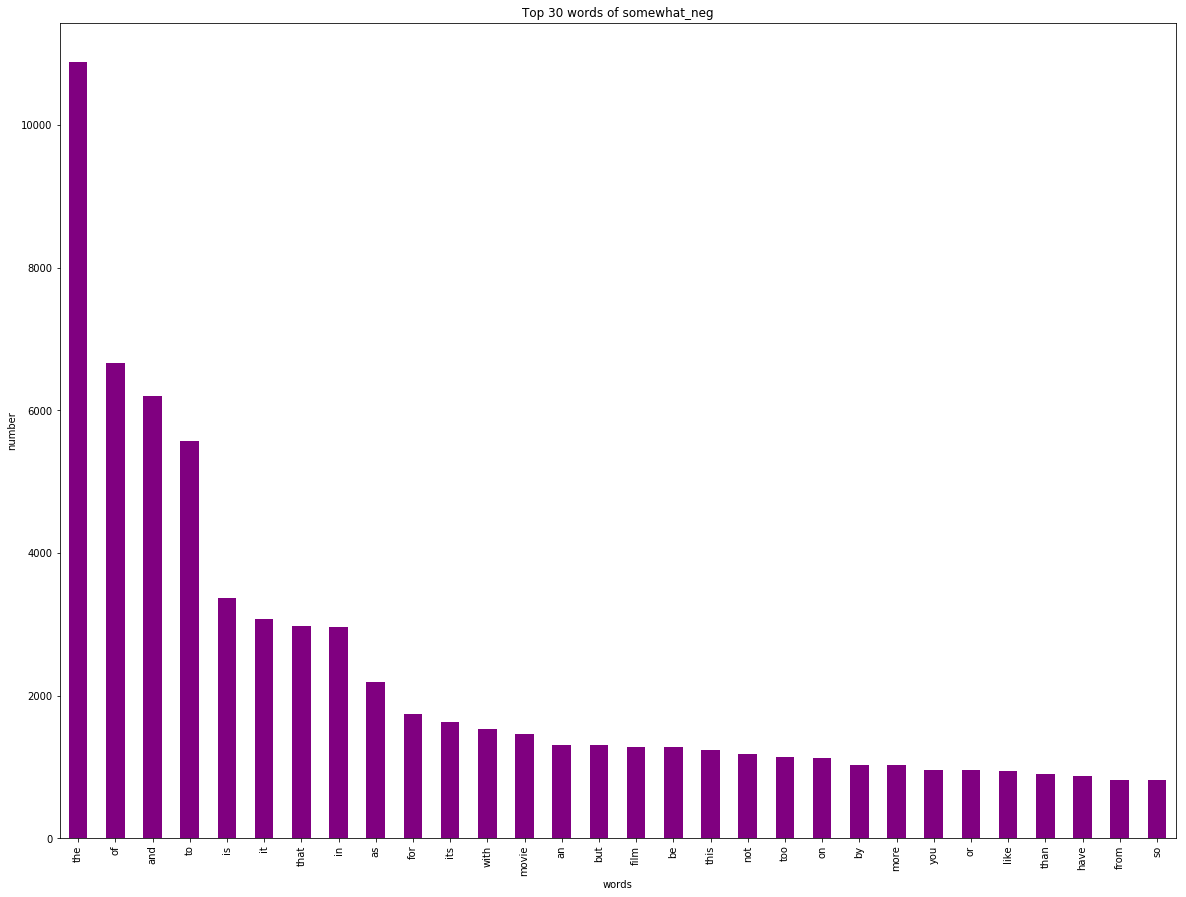

In [30]:
data2.plot.bar(legend = False, color = 'purple',figsize = (20,15))
y_somewhat_neg = np.arange(len(data2["words of somewhat_neg"]))
plt.xticks(y_somewhat_neg, data2["words of somewhat_neg"])
plt.title('Top 30 words of somewhat_neg')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

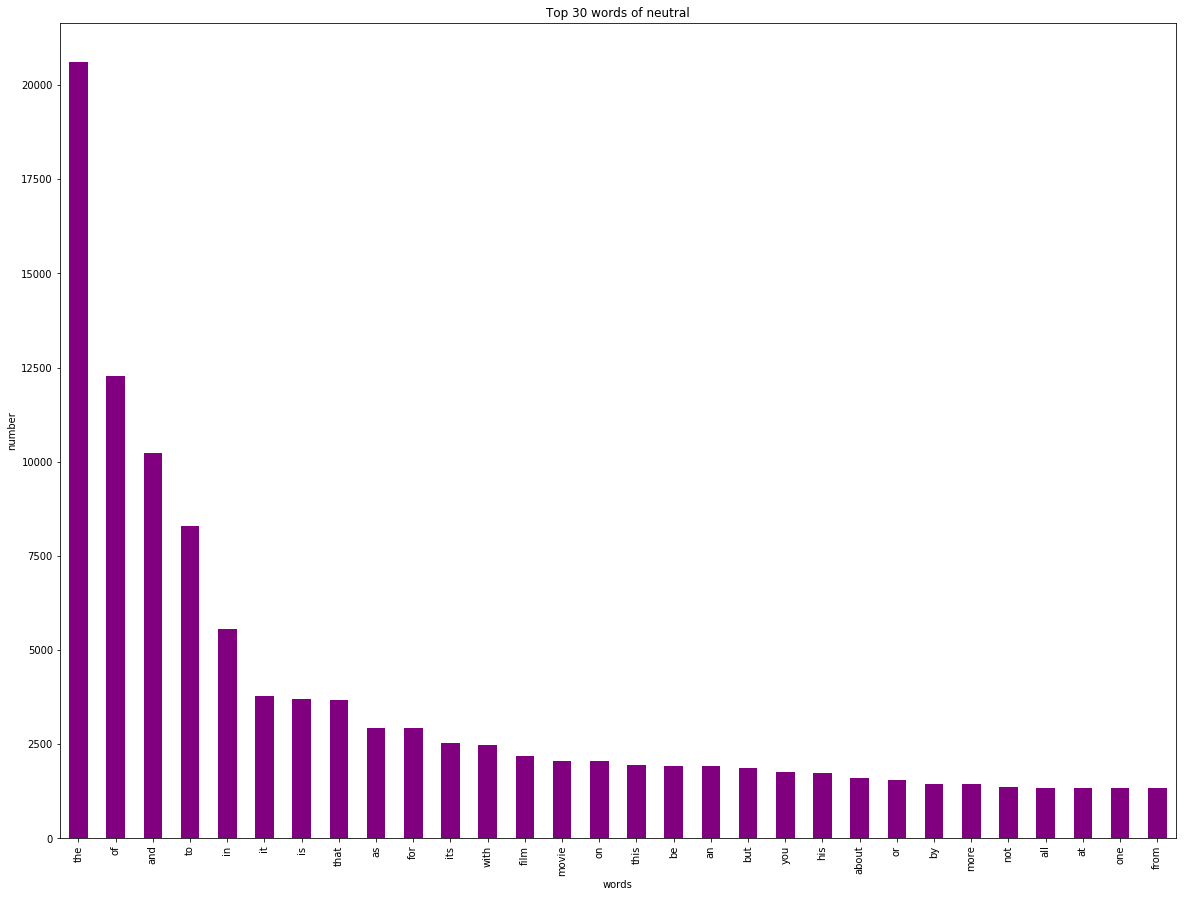

In [31]:
data3.plot.bar(legend = False, color = 'purple',figsize = (20,15))
y_neutral = np.arange(len(data3["words of neutral"]))
plt.xticks(y_neutral, data3["words of neutral"])
plt.title('Top 30 words of neutral')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

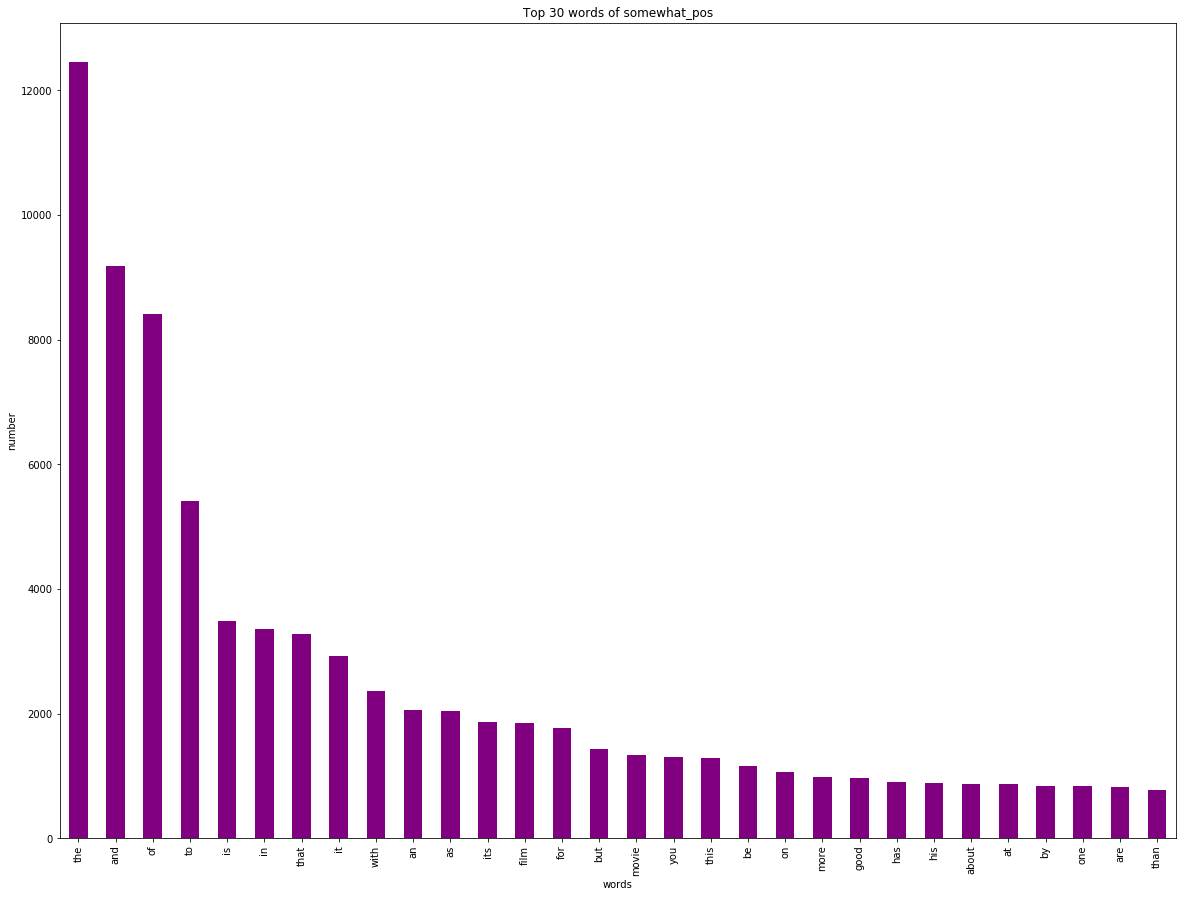

In [32]:
data4.plot.bar(legend = False, color = 'purple',figsize = (20,15))
y_somewhat_pos = np.arange(len(data4["words of somewhat_pos"]))
plt.xticks(y_somewhat_pos, data4["words of somewhat_pos"])
plt.title('Top 30 words of somewhat_pos')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

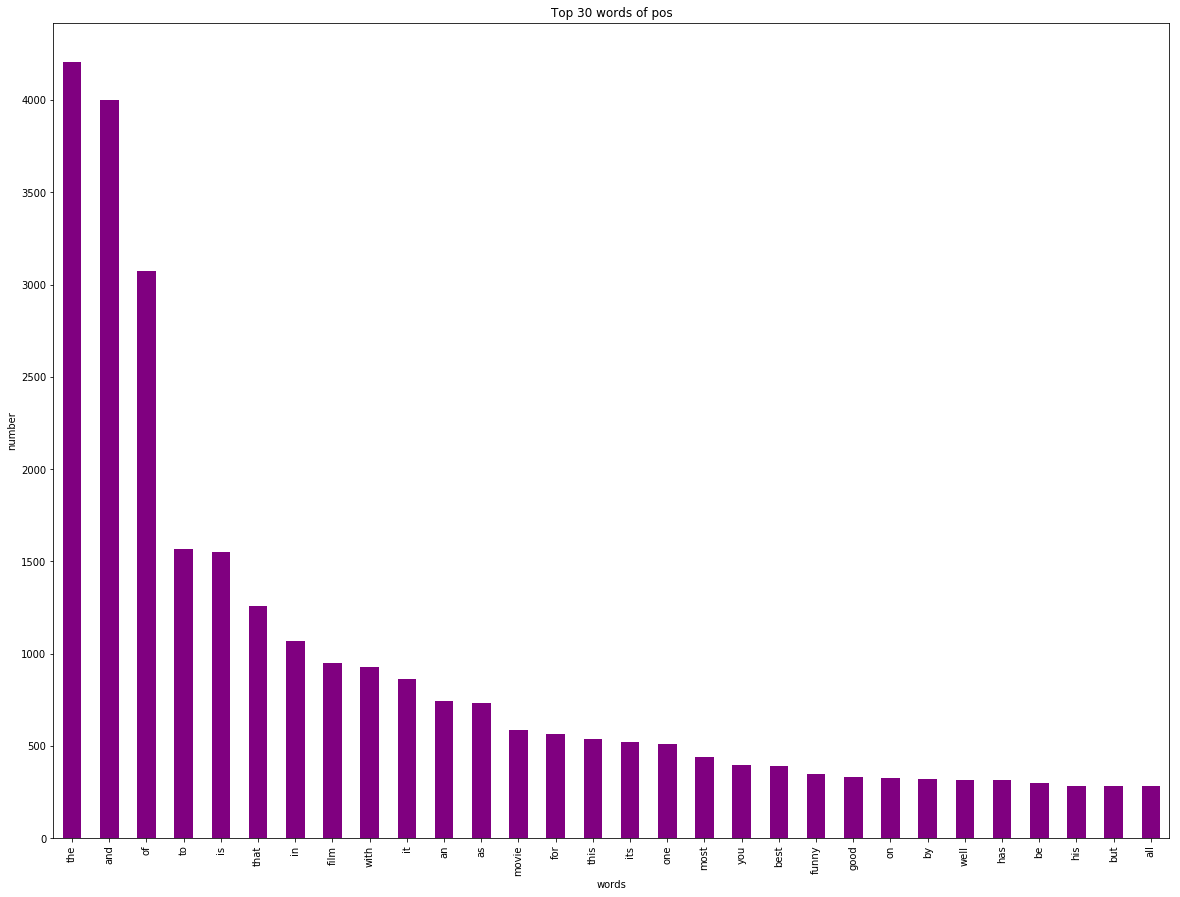

In [33]:
data5.plot.bar(legend = False, color = 'purple',figsize = (20,15))
y_pos = np.arange(len(data5["words of pos"]))
plt.xticks(y_pos, data5["words of pos"])
plt.title('Top 30 words of pos')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

word cloud train

In [34]:
all_string = []
for t in cleaned_train_data.Phrase:
    all_string.append(t)
all_string = pd.Series(all_string).str.cat(sep=' ')

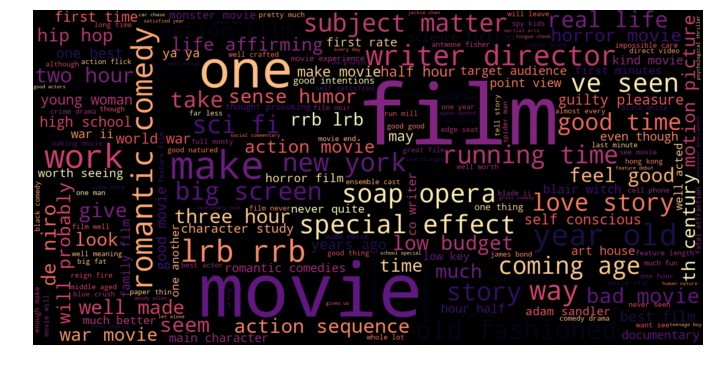

In [35]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(all_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

word cloud test

In [36]:
all_string = []
for t in cleaned_test_data.Phrase:
    all_string.append(t)
all_string = pd.Series(all_string).str.cat(sep=' ')

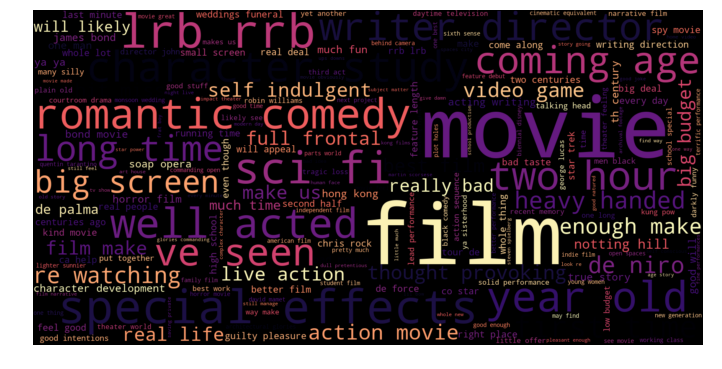

In [37]:
wordcloud = WordCloud(width=1600, height=800,max_font_size=200,colormap='magma').generate(all_string)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

# Models

## NaiveBayesClassifier with multiple Ngram (unigram and bigram)

In [38]:
stopwords_english = stopwords.words('english')

In [39]:
# clean words, i.e. remove stopwords and punctuation
def clean_words(words, stopwords_english):
    words_clean = []
#     print(type(words))
    for word in words:
        word = word.lower()
        if word not in stopwords_english and word not in string.punctuation:
            words_clean.append(word)    
    return words_clean 

In [40]:
# feature extractor function for unigram
def bag_of_words(words):    
    words_dictionary = dict([word, True] for word in words)    
    return words_dictionary

In [41]:
# feature extractor function for ngrams (bigram)
def bag_of_ngrams(words, n=2):
    words_ng = []
    for item in iter(ngrams(words, n)):
        words_ng.append(item)
    words_dictionary = dict([word, True] for word in words_ng)    
    return words_dictionary

In [42]:
from nltk.tokenize import word_tokenize
text = "It was a very good movie."
words = word_tokenize(text.lower())
words

['it', 'was', 'a', 'very', 'good', 'movie', '.']

In [43]:
bag_of_ngrams(words)

{('it', 'was'): True,
 ('was', 'a'): True,
 ('a', 'very'): True,
 ('very', 'good'): True,
 ('good', 'movie'): True,
 ('movie', '.'): True}

In [44]:
words_clean = clean_words(words, stopwords_english)
words_clean

['good', 'movie']

In [45]:
important_words = ['above', 'below', 'off', 'over', 'under', 'more', 'most', 'such', 'no', 'nor', 'not', 'only', 'so', 'than', 'too', 'very', 'just', 'but']

In [46]:
stopwords_english_for_bigrams = set(stopwords_english) - set(important_words)

In [47]:
words_clean_for_bigrams = clean_words(words, stopwords_english_for_bigrams)
words_clean_for_bigrams

['very', 'good', 'movie']

In [48]:
unigram_features = bag_of_words(words_clean)
unigram_features

{'good': True, 'movie': True}

In [49]:
bigram_features = bag_of_ngrams(words_clean_for_bigrams)
bigram_features

{('very', 'good'): True, ('good', 'movie'): True}

In [50]:
# combine both unigram and bigram features
all_features = unigram_features.copy()
all_features.update(bigram_features)
all_features

{'good': True, 'movie': True, ('very', 'good'): True, ('good', 'movie'): True}

In [51]:
# let's define a new function that extracts all features
# i.e. that extracts both unigram and bigrams features
def bag_of_all_words(words, n=2):
    words_clean = clean_words(words, stopwords_english)
    words_clean_for_bigrams = clean_words(words, stopwords_english_for_bigrams)
 
    unigram_features = bag_of_words(words_clean)
    bigram_features = bag_of_ngrams(words_clean_for_bigrams)
 
    all_features = unigram_features.copy()
    all_features.update(bigram_features)
 
    return all_features

In [52]:
bag_of_all_words(words)

{'good': True, 'movie': True, ('very', 'good'): True, ('good', 'movie'): True}

In [53]:
neg_reviews = [row for row in cleaned_train_data[cleaned_train_data.Sentiment == 0].Phrase.str.split()]
neg_reviews[0]

['would', 'have', 'hard', 'time', 'sitting', 'through', 'this', 'one']

In [54]:
somewhat_neg_reviews = [row for row in cleaned_train_data[cleaned_train_data.Sentiment == 1].Phrase.str.split()]
somewhat_neg_reviews[0]

['series',
 'of',
 'escapades',
 'demonstrating',
 'the',
 'adage',
 'that',
 'what',
 'is',
 'good',
 'for',
 'the',
 'goose',
 'is',
 'also',
 'good',
 'for',
 'the',
 'gander',
 'some',
 'of',
 'which',
 'occasionally',
 'amuses',
 'but',
 'none',
 'of',
 'which',
 'amounts',
 'to',
 'much',
 'of',
 'story']

In [55]:
neutral_reviews = [row for row in cleaned_train_data[cleaned_train_data.Sentiment == 2].Phrase.str.split()]
neutral_reviews[0]

['series',
 'of',
 'escapades',
 'demonstrating',
 'the',
 'adage',
 'that',
 'what',
 'is',
 'good',
 'for',
 'the',
 'goose']

In [56]:
somewhat_pos_reviews = [row for row in cleaned_train_data[cleaned_train_data.Sentiment == 3].Phrase.str.split()]
somewhat_pos_reviews[0]

['good', 'for', 'the', 'goose']

In [57]:
pos_reviews = [row for row in cleaned_train_data[cleaned_train_data.Sentiment == 4].Phrase.str.split()]
pos_reviews[0]

['this',
 'quiet',
 'introspective',
 'and',
 'entertaining',
 'independent',
 'is',
 'worth',
 'seeking']

In [58]:
neg_reviews_set = []
for words in neg_reviews:
#     print(words)
    neg_reviews_set.append((bag_of_all_words(words), '0'))
neg_reviews_set[0]

({'would': True,
  'hard': True,
  'time': True,
  'sitting': True,
  'one': True,
  ('would', 'hard'): True,
  ('hard', 'time'): True,
  ('time', 'sitting'): True,
  ('sitting', 'one'): True},
 '0')

In [59]:
somewhat_neg_reviews_set = []
for words in somewhat_neg_reviews:
#     print(words)
    somewhat_neg_reviews_set.append((bag_of_all_words(words), '1'))
somewhat_neg_reviews_set[0]

({'series': True,
  'escapades': True,
  'demonstrating': True,
  'adage': True,
  'good': True,
  'goose': True,
  'also': True,
  'gander': True,
  'occasionally': True,
  'amuses': True,
  'none': True,
  'amounts': True,
  'much': True,
  'story': True,
  ('series', 'escapades'): True,
  ('escapades', 'demonstrating'): True,
  ('demonstrating', 'adage'): True,
  ('adage', 'good'): True,
  ('good', 'goose'): True,
  ('goose', 'also'): True,
  ('also', 'good'): True,
  ('good', 'gander'): True,
  ('gander', 'occasionally'): True,
  ('occasionally', 'amuses'): True,
  ('amuses', 'but'): True,
  ('but', 'none'): True,
  ('none', 'amounts'): True,
  ('amounts', 'much'): True,
  ('much', 'story'): True},
 '1')

In [60]:
neutral_reviews_set = []
for words in neutral_reviews:
#     print(words)
    neutral_reviews_set.append((bag_of_all_words(words), '2'))
neutral_reviews_set[0]

({'series': True,
  'escapades': True,
  'demonstrating': True,
  'adage': True,
  'good': True,
  'goose': True,
  ('series', 'escapades'): True,
  ('escapades', 'demonstrating'): True,
  ('demonstrating', 'adage'): True,
  ('adage', 'good'): True,
  ('good', 'goose'): True},
 '2')

In [61]:
somewhat_pos_reviews_set = []
for words in somewhat_pos_reviews:
#     print(words)
    somewhat_pos_reviews_set.append((bag_of_all_words(words), '3'))
somewhat_pos_reviews_set[0]

({'good': True, 'goose': True, ('good', 'goose'): True}, '3')

In [62]:
pos_reviews_set = []
for words in pos_reviews:
#     print(words)
    pos_reviews_set.append((bag_of_all_words(words), '4'))
pos_reviews_set[0]

({'quiet': True,
  'introspective': True,
  'entertaining': True,
  'independent': True,
  'worth': True,
  'seeking': True,
  ('quiet', 'introspective'): True,
  ('introspective', 'entertaining'): True,
  ('entertaining', 'independent'): True,
  ('independent', 'worth'): True,
  ('worth', 'seeking'): True},
 '4')

In [63]:
print (len(neg_reviews_set), len(somewhat_neg_reviews_set), len(neutral_reviews_set), len(somewhat_pos_reviews_set), len(pos_reviews_set)) 
print (len(neg_reviews_set)+len(somewhat_neg_reviews_set)+len(neutral_reviews_set)+len(somewhat_pos_reviews_set)+len(pos_reviews_set)) 

# radomize pos_reviews_set and neg_reviews_set
# doing so will output different accuracy result everytime we run the program
from random import shuffle 
shuffle(neg_reviews_set)
shuffle(somewhat_neg_reviews_set)
shuffle(neutral_reviews_set)
shuffle(somewhat_pos_reviews_set)
shuffle(pos_reviews_set)

test_set = neg_reviews_set[:int((0.2*len(neg_reviews_set)))] + somewhat_neg_reviews_set[:int((0.2*len(somewhat_neg_reviews_set)))] + neutral_reviews_set[:int((0.2*len(neutral_reviews_set)))] + somewhat_pos_reviews_set[:int((0.2*len(somewhat_pos_reviews_set)))] + pos_reviews_set[:int((0.2*len(pos_reviews_set)))]
train_set = neg_reviews_set[int((0.2*len(neg_reviews_set))):] + somewhat_neg_reviews_set[int((0.2*len(somewhat_neg_reviews_set))):] + neutral_reviews_set[int((0.2*len(neutral_reviews_set))):] + somewhat_pos_reviews_set[int((0.2*len(somewhat_pos_reviews_set))):] + pos_reviews_set[int((0.2*len(pos_reviews_set))):]
 
print(len(test_set),  len(train_set))

7072 27269 79303 32917 9206
155767
31151 124616


In [64]:
%%time
from nltk import classify
from nltk import NaiveBayesClassifier
 
classifier = NaiveBayesClassifier.train(train_set)
 
accuracy = classify.accuracy(classifier, test_set)
print(accuracy)
 
print (classifier.show_most_informative_features(10)) 

0.4056691598985586
Most Informative Features
                   worse = True                0 : 3      =    172.2 : 1.0
                   solid = True                4 : 1      =    170.8 : 1.0
        ('bad', 'movie') = True                0 : 3      =    159.8 : 1.0
         ('one', 'best') = True                4 : 2      =    131.7 : 1.0
                slapdash = True                0 : 2      =    130.8 : 1.0
                  stupid = True                0 : 3      =    129.4 : 1.0
                wickedly = True                4 : 2      =    129.2 : 1.0
       ('well', 'worth') = True                4 : 2      =    123.5 : 1.0
                    junk = True                0 : 2      =    115.8 : 1.0
                    zero = True                0 : 2      =    115.8 : 1.0
None
CPU times: user 17.4 s, sys: 528 ms, total: 17.9 s
Wall time: 18.1 s


## Split Data to train and test

In [26]:
X_train, X_test, y_train, y_test = train_test_split(cleaned_train_data['Phrase'], cleaned_train_data['Sentiment'], test_size = 0.2, random_state = 37)
print ("X_train: ", len(X_train))
print("X_test: ", len(X_test))
print("y_train: ", len(y_train))
print("y_test: ", len(y_test))

X_train:  124613
X_test:  31154
y_train:  124613
y_test:  31154


In [27]:
cv = CountVectorizer(max_features = 1500)
cv.fit(X_train)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=1500, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [28]:
X_train_cv = cv.transform(X_train)
X_train_cv

<124613x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 563793 stored elements in Compressed Sparse Row format>

In [29]:
X_test_cv = cv.transform(X_test)
X_test_cv

<31154x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 140129 stored elements in Compressed Sparse Row format>

## MultiNominal Naive Bayes

In [69]:
%%time
mnb = MultinomialNB(alpha = 0.5)
MNB_model = mnb.fit(X_train_cv,y_train)

y_mnb = mnb.predict(X_test_cv)

CPU times: user 45 ms, sys: 18.6 ms, total: 63.7 ms
Wall time: 70.3 ms


In [70]:
print('Naive Bayes Accuracy: ', accuracy_score(y_mnb , y_test))
print('Naive Bayes confusion_matrix: ', confusion_matrix(y_mnb, y_test))
MNB_accuracy_train  = round(MNB_model.score(X_test_cv,y_test) * 100, 2)
MNB_accuracy_train

Naive Bayes Accuracy:  0.5841304487385247
Naive Bayes confusion_matrix:  [[  223   170    44    19     5]
 [  422  1166   668   222    50]
 [  694  3792 14416  4017   607]
 [   66   285   820  2005   765]
 [    7    27    40   236   388]]


58.41

## SVM (Support Vector Machine)

In [71]:
%%time
svc = SVC(kernel='sigmoid', gamma=1.0)
SVC_model = svc.fit(X_train_cv,y_train)

y_svc = svc.predict(X_test_cv)

CPU times: user 40min 59s, sys: 51.4 s, total: 41min 50s
Wall time: 42min 27s


In [72]:
print('SVM Accuracy: ', accuracy_score(y_svc , y_test))
print('SVM confusion_matrix: ', confusion_matrix(y_svc, y_test))
SVC_accuracy_train  = round(SVC_model.score(X_test_cv,y_test) * 100, 2)
SVC_accuracy_train 

SVM Accuracy:  0.42803492328432946
SVM confusion_matrix:  [[  155   371   467   403   151]
 [  135   434   539   383   144]
 [  746  3118 10884  3830   984]
 [  364  1481  4055  1846   520]
 [   12    36    43    37    16]]


42.8

## KNN Classification

In [73]:
%%time
knc = KNeighborsClassifier(n_neighbors=100)
KNNC_model = knc.fit(X_train_cv,y_train)

y_knc = knc.predict(X_test_cv)

CPU times: user 1min 54s, sys: 1min 2s, total: 2min 56s
Wall time: 2min 44s


In [74]:
print('KNeighbors Accuracy_score: ',accuracy_score(y_test,y_knc))
print('KNeighbors confusion_matrix: ', confusion_matrix(y_test, y_knc))
KNNC_accuracy_train  = round(KNNC_model.score(X_test_cv,y_test) * 100, 2)
KNNC_accuracy_train 

KNeighbors Accuracy_score:  0.5156320215702639
KNeighbors confusion_matrix:  [[    1    11  1400     0     0]
 [    1    39  5390    10     0]
 [    0    10 15966    12     0]
 [    0     2  6440    56     1]
 [    0     0  1770    43     2]]


51.56

## Decision Tree

In [75]:
%%time
dtc = DecisionTreeClassifier()
DTC_model = dtc.fit(X_train_cv,y_train)

y_dtc = dtc.predict(X_test_cv)

CPU times: user 24.1 s, sys: 105 ms, total: 24.2 s
Wall time: 24.1 s


In [76]:
print('Decision Tree Accuracy: ',accuracy_score(y_test,y_dtc))
print('Decision Tree confusion_matrix: ', confusion_matrix(y_dtc, y_test)) 
DTC_accuracy_train  = round(DTC_model.score(X_test_cv,y_test) * 100, 2)
DTC_accuracy_train 

Decision Tree Accuracy:  0.5853501958015022
Decision Tree confusion_matrix:  [[  498   587   217    48    19]
 [  549  2163  1722   372    55]
 [  301  2397 12337  2915   343]
 [   57   262  1577  2625   785]
 [    7    31   135   539   613]]


58.54

## Extra Tree Classification

In [77]:
%%time
etc = ExtraTreesClassifier(n_estimators=37, random_state=252)
ETC_model = etc.fit(X_train_cv,y_train)

y_etc = etc.predict(X_test_cv)

CPU times: user 4min 44s, sys: 956 ms, total: 4min 45s
Wall time: 4min 46s


In [78]:
print('Extra Tree Accuracy_score: ',accuracy_score(y_test,y_etc))
print('Extra Tree confusion_matrix: ', confusion_matrix(y_etc, y_test))
ETC_accuracy_train  = round(ETC_model.score(X_test_cv,y_test) * 100, 2)
ETC_accuracy_train 

Extra Tree Accuracy_score:  0.6099698273094948
Extra Tree confusion_matrix:  [[  495   522   152    17     5]
 [  587  2249  1527   238    25]
 [  291  2447 12739  2838   294]
 [   38   210  1475  2861   832]
 [    1    12    95   545   659]]


61.0

## Random Forest Classification¶

In [79]:
%%time
rfc = RandomForestClassifier(n_estimators=37, random_state=252)
RFC_model = rfc.fit(X_train_cv,y_train)

y_rfc = rfc.predict(X_test_cv)

CPU times: user 3min 15s, sys: 716 ms, total: 3min 16s
Wall time: 3min 16s


In [80]:
print('Random Forest Accuracy_score: ',accuracy_score(y_test,y_rfc))
print('Random Forest confusion_matrix: ', confusion_matrix(y_rfc, y_test)) 
RFC_accuracy_train  = round(RFC_model.score(X_test_cv,y_test) * 100, 2)
RFC_accuracy_train 

Random Forest Accuracy_score:  0.6096488412402902
Random Forest confusion_matrix:  [[  457   458   131    17     4]
 [  588  2148  1342   190    20]
 [  326  2585 12911  2914   304]
 [   36   235  1504  2810   820]
 [    5    14   100   568   667]]


60.96

## Adaptive Boosting Classification

In [81]:
%%time
abc = AdaBoostClassifier(n_estimators=37, random_state=252)
ABC_model = abc.fit(X_train_cv,y_train)

y_abc = abc.predict(X_test_cv)

CPU times: user 7.74 s, sys: 508 ms, total: 8.25 s
Wall time: 4.17 s


In [82]:
print('AdaBoost Accuracy_score: ',accuracy_score(y_test,y_abc))
print('AdaBoost confusion_matrix: ', confusion_matrix(y_abc, y_test))
ABC_accuracy_train  = round(ABC_model.score(X_test_cv,y_test) * 100, 2)
ABC_accuracy_train 

AdaBoost Accuracy_score:  0.5343134107979713
AdaBoost confusion_matrix:  [[  114    97    45    24     5]
 [  155   306   194   101    39]
 [  972  4576 15212  5404  1150]
 [  156   406   455   839   446]
 [   15    55    82   131   175]]


53.43

## Bagging Classification

In [83]:
%%time
bc = BaggingClassifier(n_estimators=9, random_state=252)
BC_model = bc.fit(X_train_cv,y_train)

y_bc = bc.predict(X_test_cv)

CPU times: user 3min 7s, sys: 666 ms, total: 3min 8s
Wall time: 3min 7s


In [84]:
print('Bagging Accuracy_score: ',accuracy_score(y_test,y_bc))
print('Bagging confusion_matrix: ', confusion_matrix(y_bc, y_test))
BC_accuracy_train  = round(BC_model.score(X_test_cv,y_test) * 100, 2)
BC_accuracy_train 

Bagging Accuracy_score:  0.5963600179752199
Bagging confusion_matrix:  [[  447   462   147    27     8]
 [  583  2157  1507   256    43]
 [  321  2516 12600  2902   305]
 [   51   275  1603  2732   816]
 [   10    30   131   582   643]]


59.64

## Logistic Reg

In [85]:
%%time
log_model = LogisticRegression()
LRC_model = log_model.fit(X_train_cv,y_train)

y_lr = log_model.predict(X_test_cv)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


CPU times: user 9.07 s, sys: 105 ms, total: 9.18 s
Wall time: 9.07 s


In [86]:
print('LR Accuracy_score: ',accuracy_score(y_test,y_bc))
print('LR confusion_matrix: ', confusion_matrix(y_bc, y_test)) 
LRC_accuracy_train  = round(LRC_model.score(X_test_cv,y_test) * 100, 2)
LRC_accuracy_train

LR Accuracy_score:  0.5963600179752199
LR confusion_matrix:  [[  447   462   147    27     8]
 [  583  2157  1507   256    43]
 [  321  2516 12600  2902   305]
 [   51   275  1603  2732   816]
 [   10    30   131   582   643]]


59.0

In [87]:
# coefficeints of the trained model
print('Coefficient of model :', log_model.coef_)
print('-'*45)
# intercept of the model
print('Intercept of model',log_model.intercept_)

Coefficient of model : [[-0.9540081   0.31550261  0.01151965 ...  0.36424765  1.09422161
  -0.39630583]
 [-1.04248817 -0.23452064 -0.07621774 ...  0.00350775  0.36279519
  -0.43829374]
 [-0.65508256 -0.68099532  0.16782053 ... -0.05161886 -0.50520726
   0.23210391]
 [ 1.13391878  0.09181799 -0.05827228 ... -0.1778027  -0.43001042
   0.47750469]
 [ 1.33844268  1.31552358 -0.21290876 ...  0.0429314  -0.23580274
  -0.1620032 ]]
---------------------------------------------
Intercept of model [-3.95284203 -1.90265461  0.90273884 -1.67354606 -3.81786979]


## Gradian Boosting Tunning (GBM)

In [91]:
from sklearn.ensemble import GradientBoostingClassifier

In [92]:
%%time
gbm_model = GradientBoostingClassifier()
GBM_model = gbm_model.fit(X_train_cv,y_train)

y_gbm = gbm_model.predict(X_test_cv)

CPU times: user 2min 19s, sys: 6.57 s, total: 2min 25s
Wall time: 1min 14s


In [93]:
print('GBM Accuracy_score: ',accuracy_score(y_test,y_gbm))
print('GBM confusion_matrix: ', confusion_matrix(y_gbm, y_test))
GBM_accuracy_train  = round(GBM_model.score(X_test_cv,y_test) * 100, 2)
GBM_accuracy_train

GBM Accuracy_score:  0.5466713744623484
GBM confusion_matrix:  [[  141    65    20     5     0]
 [  191   479   235   113    22]
 [  954  4550 15333  5393  1190]
 [  123   335   377   908   433]
 [    3    11    23    80   170]]


54.67

In [1]:

models = pd.DataFrame({
    'Model': ['MultinominalNB','SVM','KNN','Decision Tree','Extra Classification','Random Forest','AdaBost','Bagging Classification','Logistic Regression','GBM'],
    'Accuray Score': [MNB_accuracy_train,SVC_accuracy_train,KNNC_accuracy_train,DTC_accuracy_train,ETC_accuracy_train,RFC_accuracy_train,ABC_accuracy_train,BC_accuracy_train,LRC_accuracy_train,GBM_accuracy_train]
})
models.sort_values(by='Accuray Score', ascending=False)

NameError: name 'pd' is not defined

## Compare

In [229]:
X_train_cv2 = cv.transform(cleaned_test_data['Phrase'])
X_train_cv2

<66122x1500 sparse matrix of type '<class 'numpy.int64'>'
	with 272381 stored elements in Compressed Sparse Row format>

In [230]:
phrase_id = cleaned_test_data['PhraseId'].values

In [231]:
len(phrase_id)

66122

In [232]:
test_predictions = mnb.predict(X_train_cv2)

In [233]:
test_predictions.shape

(66122,)

In [234]:
final_answer = pd.DataFrame({'PhraseId':phrase_id,'Sentiment':test_predictions})

In [235]:
final_answer

,PhraseId,Sentiment
0,156061,1
1,156062,1
2,156063,2
3,156064,1
4,156065,2
...,...,...
66117,222348,1
66118,222349,1
66119,222350,2
66120,222351,2


# Consult